#1 - Introduction


Nama : Rahardiansyah Fatoni

Batch : RMT-027

Objective : The objective of this model is to preprocess images of rice leaf disease and train a machine learning model to identify it using Convolutional Layers from Convolutional Neural Networks. The model is trained to classify Bacterial brown, Blast, Tungro, and Brown leaf disease in rice leaf.

Dataset Source : https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image

Deploy : https://huggingface.co/spaces/Rahardiansyah/GC7

---
#2 - Import Libraries

In [ ]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

---
#3 - Data Loading

source : https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image

In [ ]:
# Install Kaggle library in Google Collaboratory

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image

!kaggle datasets download -d nirmalsankalana/rice-leaf-disease-image

 91% 177M/195M [00:04<00:00, 27.2MB/s]
100% 195M/195M [00:04<00:00, 45.2MB/s]
CPU times: user 58 ms, sys: 7.19 ms, total: 65.1 ms
Wall time: 5.44 s


In [ ]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

# Directory to unzip the dataset into
unzip_dir = "/content/dataset"

# Create the directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

!unzip ./rice-leaf-disease-image.zip -d {unzip_dir}

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_141.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_142.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_143.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_144.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_145.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_146.JPG  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_147.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_148.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_149.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_150.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_151.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_152.jpg  
  inflating: /content/dataset/Bacterialblight/BACTERIALBLIGHT1_153.jpg  


In [ ]:
# Define paths
main_path = "/content/dataset/"
train_path = "/content/train/"
test_path = "/content/test/"
classes = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

# Create train and test directories
os.makedirs(train_path)
os.makedirs(test_path)

for class_name in classes:
    class_path = os.path.join(main_path, class_name)
    images = os.listdir(class_path)
    # Split into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    for image_name in train_images:
        src = os.path.join(class_path, image_name)
        dst = os.path.join(train_path, class_name, image_name)
        shutil.copy(src, dst)

    for image_name in test_images:
        src = os.path.join(class_path, image_name)
        dst = os.path.join(test_path, class_name, image_name)
        shutil.copy(src, dst)

---
#4 - Exploratory Data Analysis (EDA)

In [ ]:
# Check how many data in all paths

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Dataset')
check_path(main_path)
print('')
print('Train Dataset')
check_path(train_path)
print('')
print('Test Dataset')
check_path(test_path)
print('')

Dataset
Total Data - Tungro : 1308
Total Data - Brownspot : 1600
Total Data - Blast : 1440
Total Data - Bacterialblight : 1584

Train Dataset
Total Data - Tungro : 1046
Total Data - Brownspot : 1280
Total Data - Blast : 1152
Total Data - Bacterialblight : 1267

Test Dataset
Total Data - Tungro : 262
Total Data - Brownspot : 320
Total Data - Blast : 288
Total Data - Bacterialblight : 317



In [ ]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  Tungro


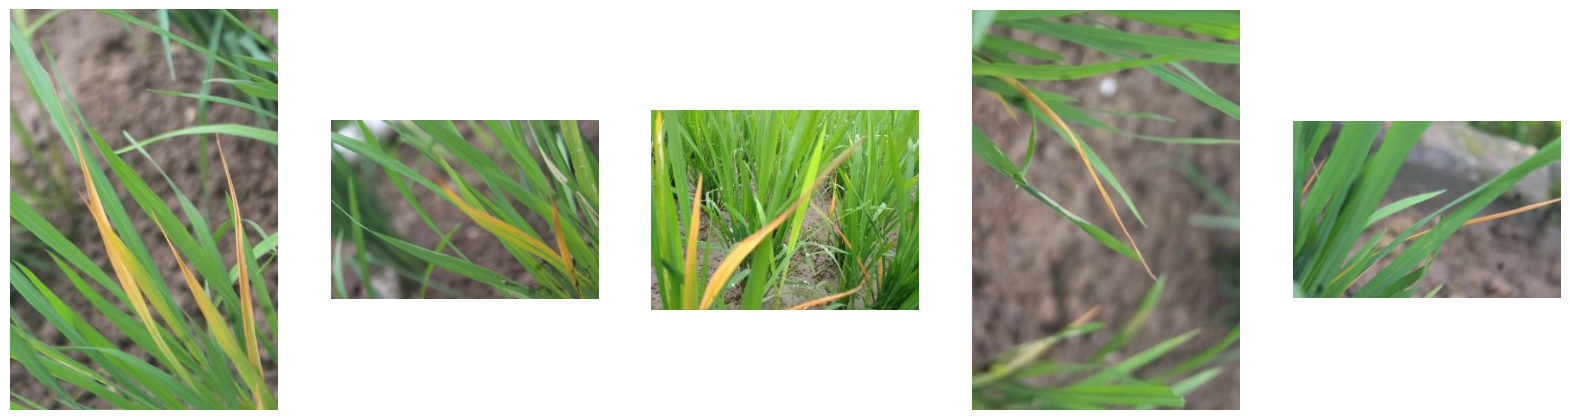

Class :  Brownspot


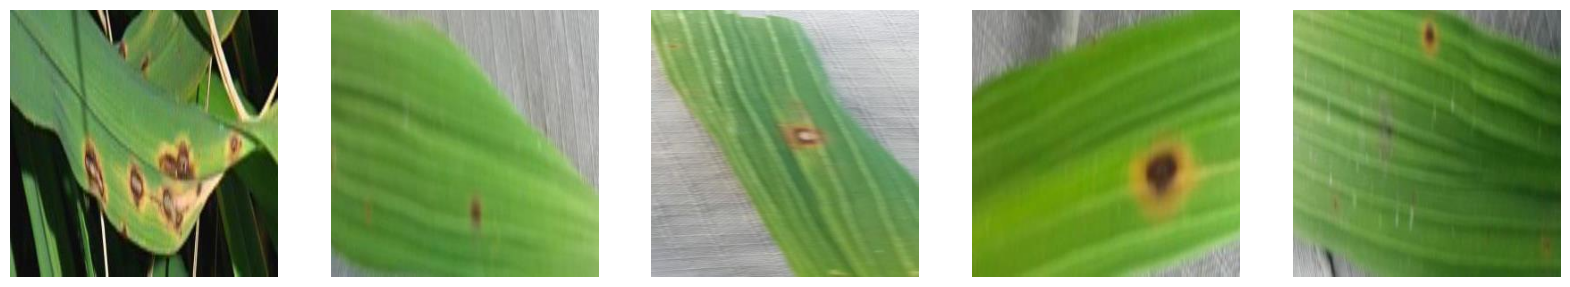

Class :  Blast


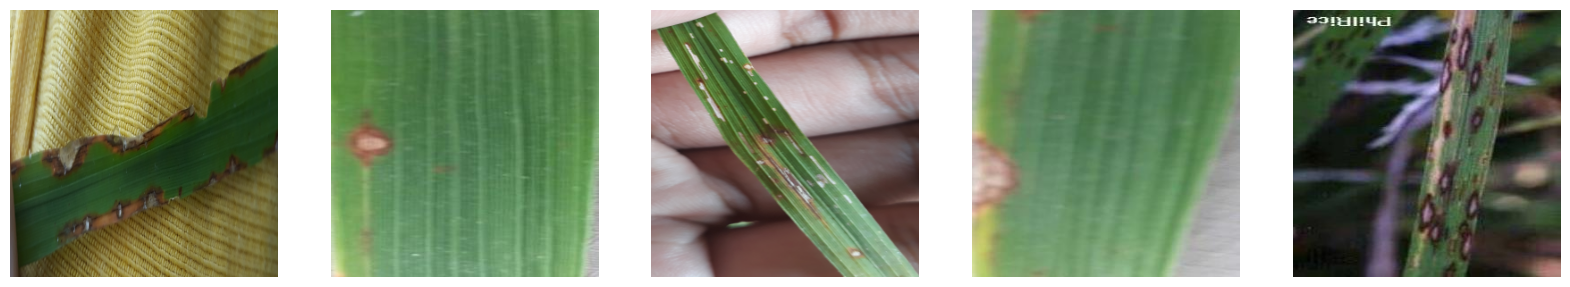

Class :  Bacterialblight


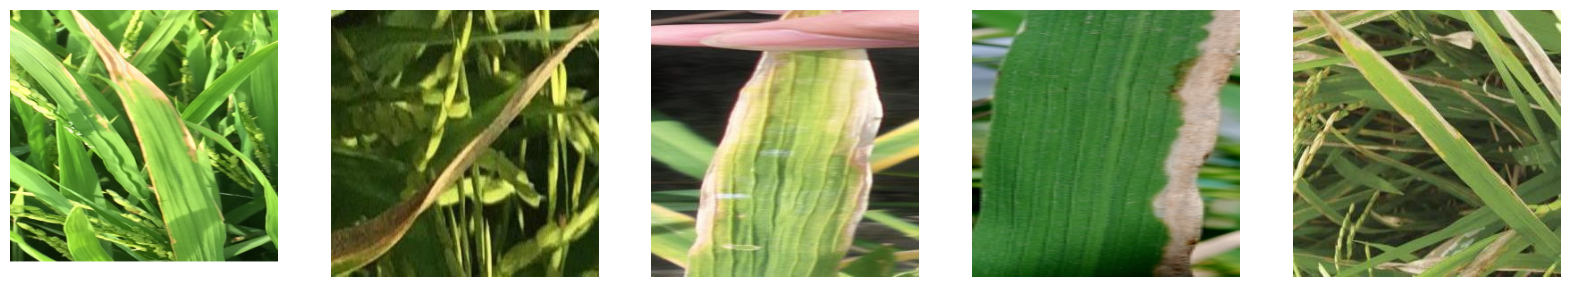

In [ ]:
# Visualization of main_path

plot_images(main_path)

$Insight:$
- Color : The dataset is mostly dominated by green and brown colors. Therefore, based on this paper (https://core.ac.uk/download/336861039.pdf), we could convert the images into LAB color space had RGB color space not suffice.
- Angle : The angle of the dataset seems to either be a close up photo of the rice leaf disease or the entirety of the rice plant.
- Others : The image size of the dataset is 300x300.

---
#5 - ANN Training (Sequential API)

##5.1 - Preprocessing

In [ ]:
# Define hyperparameters

img_height= 300
img_width= 300
batch_size= 32

In [ ]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 2849 images belonging to 4 classes.
Found 1896 images belonging to 4 classes.
Found 1187 images belonging to 4 classes.


In [ ]:
# Show labels

train_set.class_indices

{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Tungro': 3}

##5.2 - Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3), kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5, seed=seed))
model.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(Dense(4, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

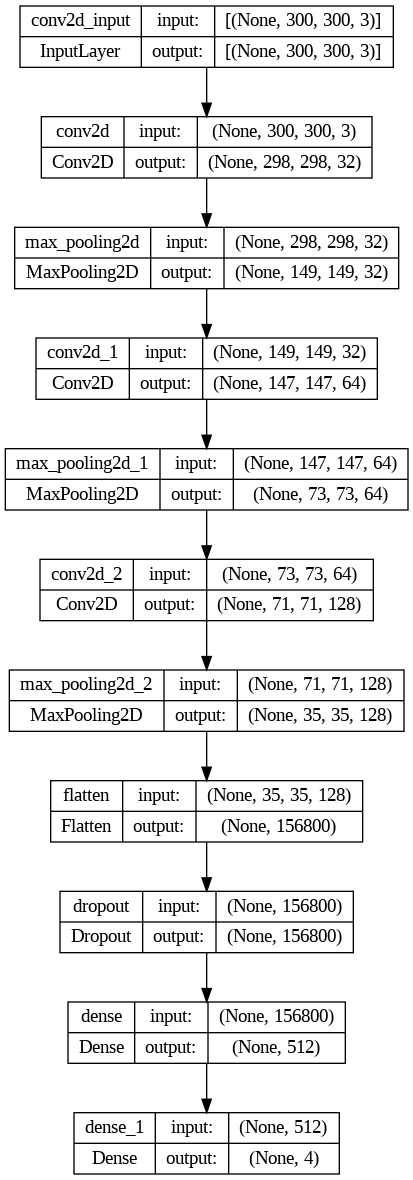

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

##5.3 - Model Training

In [ ]:
# Train the model

%%time
history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
90/90 [==============================] - 26s 243ms/step - loss: 4.7501 - accuracy: 0.6476 - val_loss: 0.5850 - val_accuracy: 0.7790
Epoch 2/20
90/90 [==============================] - 18s 205ms/step - loss: 0.4126 - accuracy: 0.8410 - val_loss: 0.4033 - val_accuracy: 0.8507
Epoch 3/20
90/90 [==============================] - 19s 211ms/step - loss: 0.1752 - accuracy: 0.9410 - val_loss: 0.3805 - val_accuracy: 0.8829
Epoch 4/20
90/90 [==============================] - 19s 210ms/step - loss: 0.0811 - accuracy: 0.9747 - val_loss: 0.1749 - val_accuracy: 0.9546
Epoch 5/20
90/90 [==============================] - 19s 211ms/step - loss: 0.0767 - accuracy: 0.9796 - val_loss: 0.4173 - val_accuracy: 0.8850
Epoch 6/20
90/90 [==============================] - 19s 213ms/step - loss: 0.0828 - accuracy: 0.9747 - val_loss: 0.3239 - val_accuracy: 0.9161
Epoch 7/20
90/90 [==============================] - 19s 206ms/step - loss: 0.0796 - accuracy: 0.9754 - val_loss: 0.3959 - val_accuracy: 0.9135

##5.4 - Model Evaluation

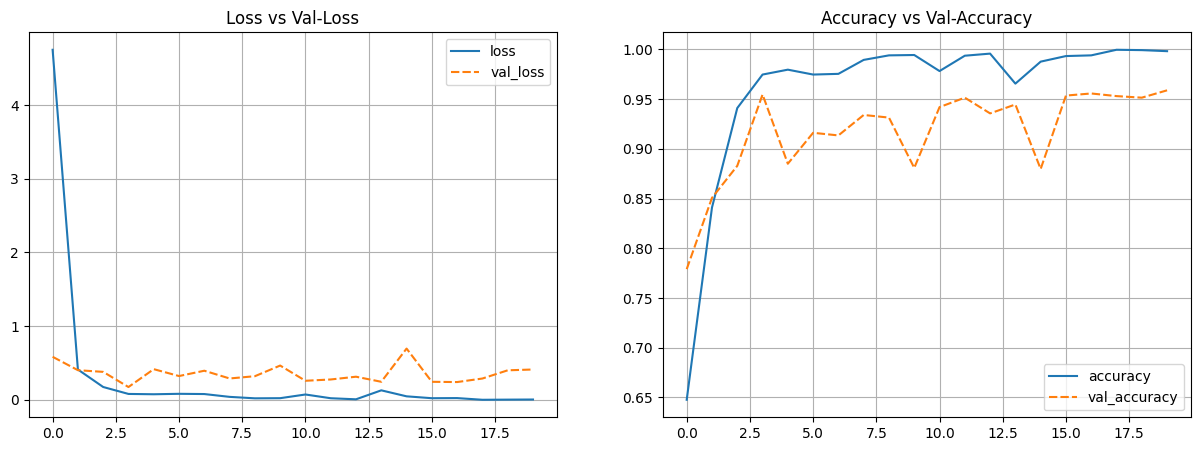

In [ ]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

                 precision    recall  f1-score   support

Bacterialblight       0.92      0.92      0.92       317
          Blast       0.91      0.93      0.92       288
      Brownspot       0.99      0.92      0.95       320
         Tungro       0.91      0.98      0.94       262

       accuracy                           0.93      1187
      macro avg       0.93      0.94      0.93      1187
   weighted avg       0.93      0.93      0.93      1187



##5.5 - Model Inference

In [ ]:
def prediction(file):
  img = tf.keras.utils.load_img(file, target_size=(300, 300))
  x = tf.keras.utils.img_to_array(img)/255

  plt.imshow(img)

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=128)
  idx = np.argmax(classes)
  clas = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
  print('Prediction is {}'.format(clas[idx]))

In [ ]:
# !wget link_image
!wget http://www.knowledgebank.irri.org/images/stories/bacterial-leaf-blight-3.JPG
!wget https://agritech.tnau.ac.in/crop_protection/images/rice_diseases/blast_1.jpg
!wget http://www.knowledgebank.irri.org/images/stories/brown-spot-3.jpg
!wget http://www.knowledgebank.irri.org/images/stories/tungro-1.jpg

--2024-02-20 03:18:41--  http://www.knowledgebank.irri.org/images/stories/bacterial-leaf-blight-3.JPG
Resolving www.knowledgebank.irri.org (www.knowledgebank.irri.org)... 18.136.241.131
Connecting to www.knowledgebank.irri.org (www.knowledgebank.irri.org)|18.136.241.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257036 (251K) [image/jpeg]
Saving to: ‘bacterial-leaf-blight-3.JPG’

bacterial-leaf-blig 100%[===================>] 251.01K   230KB/s    in 1.1s    

2024-02-20 03:18:42 (230 KB/s) - ‘bacterial-leaf-blight-3.JPG’ saved [257036/257036]

--2024-02-20 03:18:42--  https://agritech.tnau.ac.in/crop_protection/images/rice_diseases/blast_1.jpg
Resolving agritech.tnau.ac.in (agritech.tnau.ac.in)... 14.139.187.9
Connecting to agritech.tnau.ac.in (agritech.tnau.ac.in)|14.139.187.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45115 (44K) [image/jpeg]
Saving to: ‘blast_1.jpg’

blast_1.jpg         100%[===================>]  44.06K  

1/1 [==============================] - 0s 224ms/step
Prediction is Bacterialblight


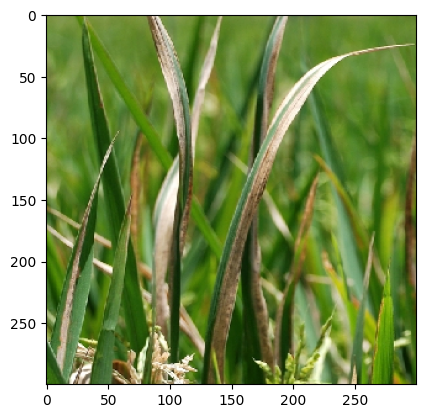

In [ ]:
prediction('bacterial-leaf-blight-3.JPG')

1/1 [==============================] - 0s 18ms/step
Prediction is Bacterialblight


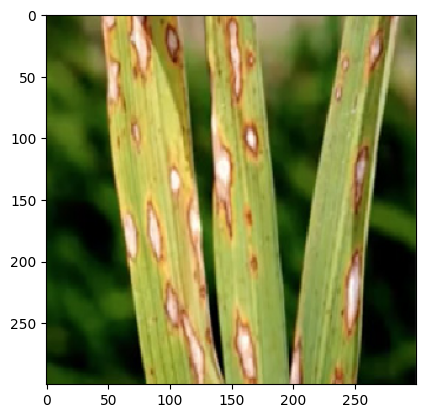

In [ ]:
prediction('blast_1.jpg')

1/1 [==============================] - 0s 18ms/step
Prediction is Bacterialblight


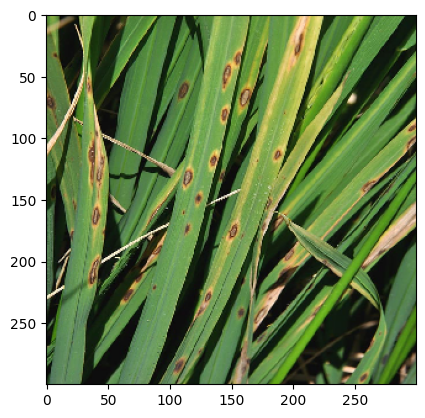

In [ ]:
prediction('brown-spot-3.jpg')

1/1 [==============================] - 0s 19ms/step
Prediction is Tungro


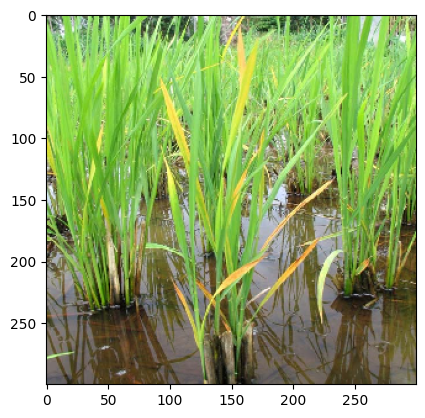

In [ ]:
prediction('tungro-1.jpg')

2 out of 4 correctly predicted.

##5.6 - Model Conclusion

$Insight:$
- As you can see, the model can only accurately predict 2 out of 4 rice leaf disease, despite having a high accuracy score.
- From the visualization we can see that the val-accuraccy and val-loss seems to fluctuate, but is generally still following a healthy trend.
- The model's simple archictecture allowed it to be trained rather quickly with each epoch averaging in around 20s.

---
#6 - ANN Improvement

- Based on our previous EDA, we will see if augmenting the data by rotating, zooming, shifting the height and weight, shearing, and flipping the images horizontally will improve the model's accuracy. The reason we're trying this is because the dataset contains varied angles and variations, for example one data shows an image of a rice leaf on a person's hand while another shows rice plant on a field.
- We will also use batch normalization on our model.
- Lastly, we will use pooling model as opposed to flatten model.

##6.1 - Preprocessing

In [ ]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=20,
                                                                zoom_range=0.05,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                shear_range=0.05,
                                                                horizontal_flip=True,
                                                                validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 2849 images belonging to 4 classes.
Found 1896 images belonging to 4 classes.
Found 1187 images belonging to 4 classes.


##6.2 - Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Next on our new model, we shall also see if batch normalization and using pooling model instead of flatten would help improve our model.

In [ ]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3), kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(tf.keras.layers.BatchNormalization())
model_aug.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(tf.keras.layers.BatchNormalization())
model_aug.add(Conv2D(128, (3,3),activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(tf.keras.layers.BatchNormalization())
model_aug.add(tf.keras.layers.GlobalAveragePooling2D())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(Dense(6, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 149, 149, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                        

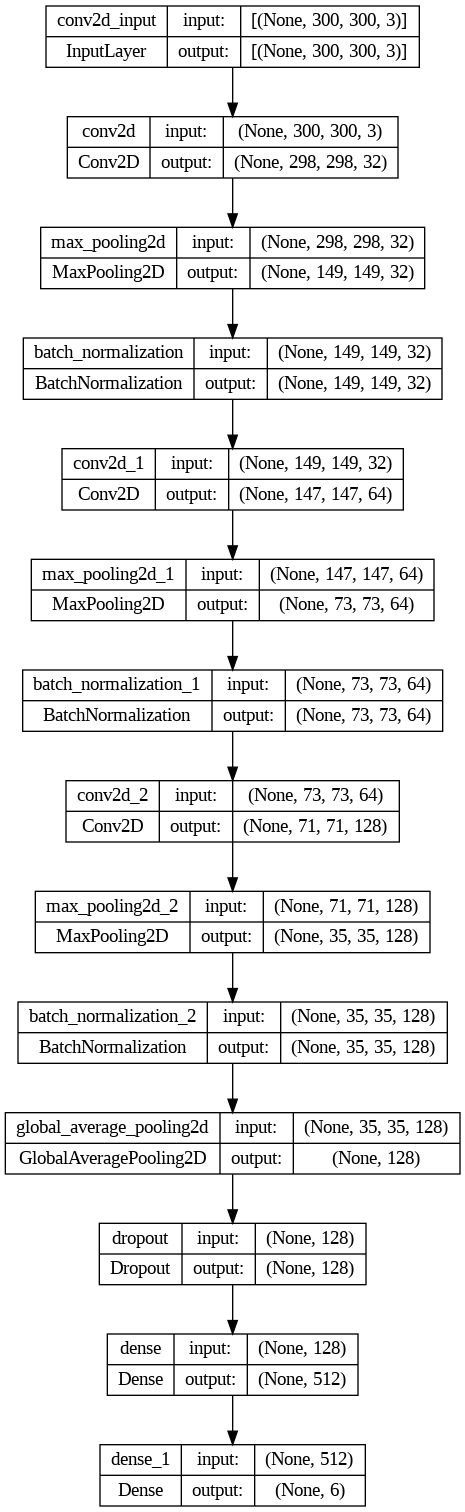

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

##6.3 - Model Training

In [ ]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=10, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/10
90/90 [==============================] - 101s 1s/step - loss: 0.6745 - accuracy: 0.7476 - val_loss: 1.7028 - val_accuracy: 0.4578
Epoch 2/10
90/90 [==============================] - 99s 1s/step - loss: 0.4355 - accuracy: 0.8420 - val_loss: 1.4370 - val_accuracy: 0.4230
Epoch 3/10
90/90 [==============================] - 99s 1s/step - loss: 0.3794 - accuracy: 0.8610 - val_loss: 1.1335 - val_accuracy: 0.6039
Epoch 4/10
90/90 [==============================] - 101s 1s/step - loss: 0.3411 - accuracy: 0.8712 - val_loss: 0.6106 - val_accuracy: 0.7226
Epoch 5/10
90/90 [==============================] - 98s 1s/step - loss: 0.2712 - accuracy: 0.8936 - val_loss: 0.4731 - val_accuracy: 0.8027
Epoch 6/10
90/90 [==============================] - 98s 1s/step - loss: 0.2196 - accuracy: 0.9175 - val_loss: 0.2466 - val_accuracy: 0.9225
Epoch 7/10
90/90 [==============================] - 99s 1s/step - loss: 0.2090 - accuracy: 0.9203 - val_loss: 0.1271 - val_accuracy: 0.9546
Epoch 8/10
90/90 [

##6.4 - Model Evaluation

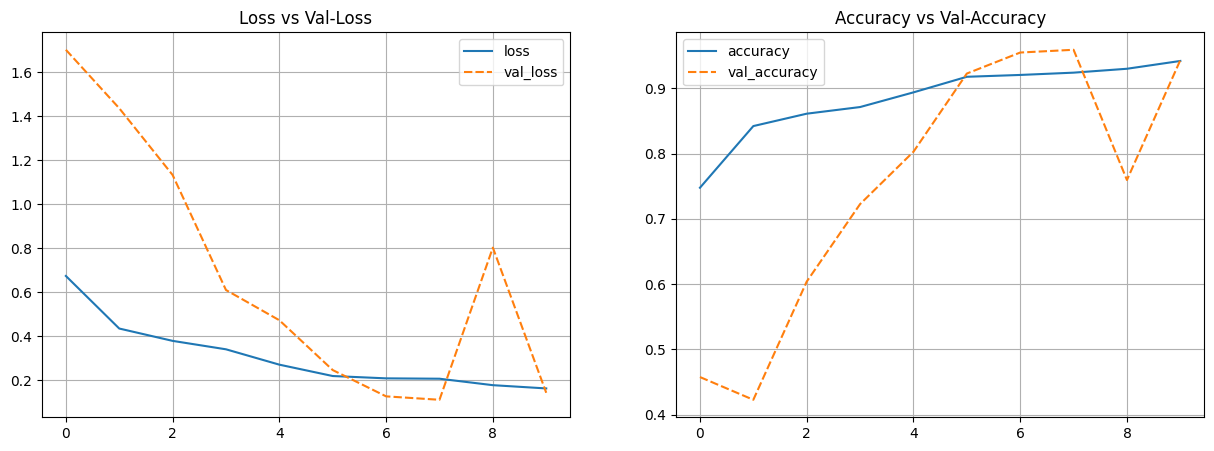

In [ ]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

                 precision    recall  f1-score   support

Bacterialblight       0.98      0.93      0.95       317
          Blast       0.92      0.90      0.91       288
      Brownspot       0.90      0.96      0.93       320
         Tungro       0.98      0.98      0.98       262

       accuracy                           0.94      1187
      macro avg       0.95      0.94      0.94      1187
   weighted avg       0.94      0.94      0.94      1187



##6.5 - Model Inference

In [ ]:
def prediction_aug(file):
  img = tf.keras.utils.load_img(file, target_size=(300, 300))
  x = tf.keras.utils.img_to_array(img)/255

  plt.imshow(img)

  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_aug.predict(images, batch_size=128)
  idx = np.argmax(classes)
  clas = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
  print('Prediction is {}'.format(clas[idx]))

1/1 [==============================] - 0s 143ms/step
Prediction is Bacterialblight


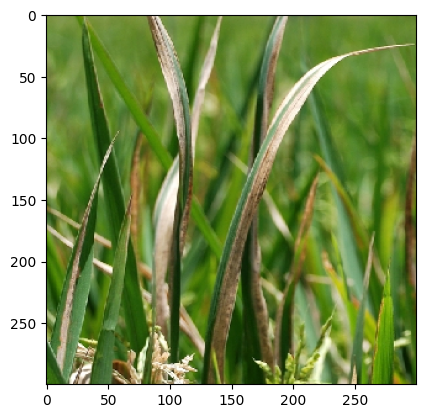

In [ ]:
prediction_aug('bacterial-leaf-blight-3.JPG')

1/1 [==============================] - 0s 26ms/step
Prediction is Brownspot


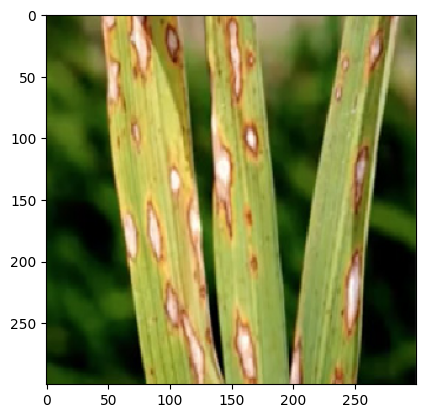

In [ ]:
prediction_aug('blast_1.jpg')

1/1 [==============================] - 0s 31ms/step
Prediction is Brownspot


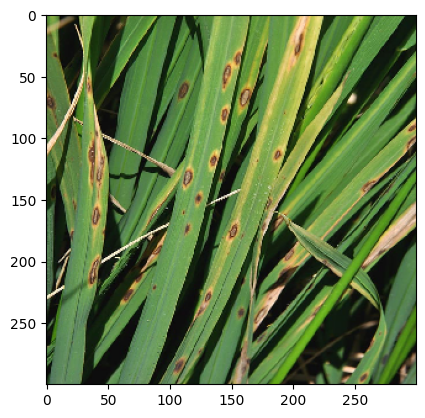

In [ ]:
prediction_aug('brown-spot-3.jpg')

1/1 [==============================] - 0s 31ms/step
Prediction is Tungro


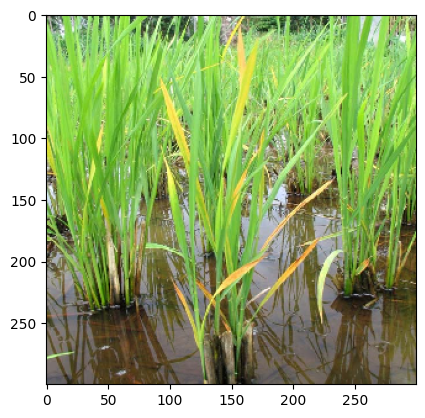

In [ ]:
prediction_aug('tungro-1.jpg')

3 out of 4 correctly predicted.

---
#7 - Model Comparison

In [ ]:
print("Classification report without data augmenting:")
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))
print("_____________________________________________________________")
print("Classification report with data augmenting:")
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

Classification report without data augmenting:
                 precision    recall  f1-score   support

Bacterialblight       0.92      0.92      0.92       317
          Blast       0.91      0.93      0.92       288
      Brownspot       0.99      0.92      0.95       320
         Tungro       0.91      0.98      0.94       262

       accuracy                           0.93      1187
      macro avg       0.93      0.94      0.93      1187
   weighted avg       0.93      0.93      0.93      1187

_____________________________________________________________
Classification report with data augmenting:
                 precision    recall  f1-score   support

Bacterialblight       0.98      0.93      0.95       317
          Blast       0.92      0.90      0.91       288
      Brownspot       0.90      0.96      0.93       320
         Tungro       0.98      0.98      0.98       262

       accuracy                           0.94      1187
      macro avg       0.95      0.94      0.

$Insight:$
- After augmenting the data, adding normalization, and using a pooling model, although we achieved similar metric scores, the new model can correctly predict 3 out of 4 new images of rice leaf disease, so an improvement have been made.
- Based on the visualization, the new model seems like it needs more epoch to see how the val-accuracy and val-loss would compare.
- The more complex new model takes around 100s/epoch.

---
#8 - Model Saving

In [ ]:
# Model summary
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 149, 149, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
# Freeze model

model_aug.trainable = False
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 149, 149, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
# Save ANN model

model_aug.save('riceleaf_model.h5')

---
#9 - Conclusion

* We have created a model to identify the 4 types of rice leaf diseases (Blight, Brown, Blast, and Tungro) with an average F1-Score of 94, an accuracy of 94%, and a loss of 0.1632. Thus, the model is deemed sufficiently accurate.

* The model's robustness to new data has also been tested and resulted in a 3 out of 4 correct prediction to new images of rice leaf disease. Thus, the model is deemed sufficiently robust.

**Strengths**:
* The model has a high f1 and accuracy score on each classes.
* The model is fairly quick to train.

**Weakness**:
* The model could only identify 4 types of rice leaf diseases, according to https://doi.org/10.3389/fpls.2021.701038, there are more types of diseases in rice leaf not included in this model, for example : rice false smut, rice neck blast, rice sheath blight, rice bacterial stripe, etc. An improved model could then be made by including more diseases varieties.
* Finally, based on our model inference tests and classification report, we could assume that the model has, in particular, a weakness to differentiate Blast disease with Bacterial Blight, to further prove this, we can refer to more model inference testing even more images of bacterial blight and blast below.

In [ ]:
# !wget link_image
# Bacterial Blight
!wget https://www.drishtiias.com/images/uploads/1601885203_image2.jpg
!wget https://kvkcachar.aau.ac.in/images/11.jpg
!wget https://pestsdiseases.com/wp-content/uploads/Bacterial-Leaf-Blight-Management-in-Paddy1.png
# Blast
!wget https://ars.els-cdn.com/content/image/3-s2.0-B9780128143834000086-u08-36-9780128143834.jpg
!wget https://www.ricefarming.com/wp-content/uploads/2019/06/2015-19-Fig-1-Blast.png
!wget https://www.oeaw.ac.at/fileadmin/_processed_/c/2/csm_DSCN2290_1_Rice_Blast_fungus_infecting_plants_-_Nick_Talbot_24f4e5c0ec.jpg

--2024-02-20 03:36:54--  https://www.drishtiias.com/images/uploads/1601885203_image2.jpg
Resolving www.drishtiias.com (www.drishtiias.com)... 104.26.13.107, 104.26.12.107, 172.67.75.51, ...
Connecting to www.drishtiias.com (www.drishtiias.com)|104.26.13.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168263 (164K) [image/jpeg]
Saving to: ‘1601885203_image2.jpg’

1601885203_image2.j 100%[===================>] 164.32K   668KB/s    in 0.2s    

2024-02-20 03:36:55 (668 KB/s) - ‘1601885203_image2.jpg’ saved [168263/168263]

--2024-02-20 03:36:55--  https://kvkcachar.aau.ac.in/images/11.jpg
Resolving kvkcachar.aau.ac.in (kvkcachar.aau.ac.in)... 14.139.222.143
Connecting to kvkcachar.aau.ac.in (kvkcachar.aau.ac.in)|14.139.222.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40384 (39K) [image/jpeg]
Saving to: ‘11.jpg’

11.jpg              100%[===================>]  39.44K   144KB/s    in 0.3s    

2024-02-20 03:36:56 (144 KB/s) - ‘1

Bacterial Blight:

1/1 [==============================] - 0s 50ms/step
Prediction is Brownspot


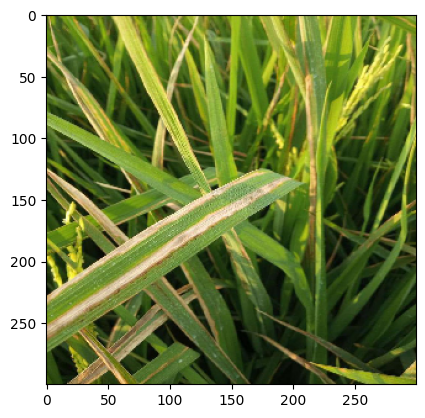

In [ ]:
prediction_aug('1601885203_image2.jpg')

1/1 [==============================] - 0s 18ms/step
Prediction is Bacterialblight


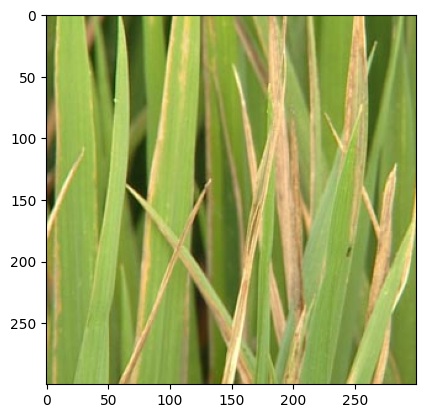

In [ ]:
prediction_aug('11.jpg')

1/1 [==============================] - 0s 19ms/step
Prediction is Bacterialblight


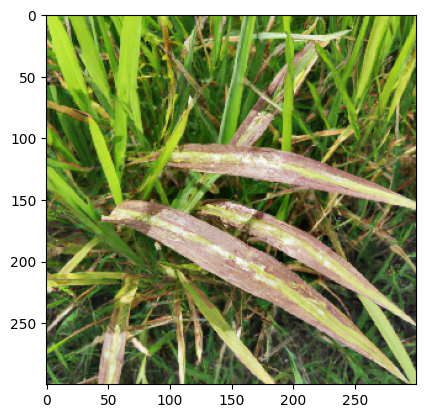

In [ ]:
prediction_aug('Bacterial-Leaf-Blight-Management-in-Paddy1.png')

Blast:

1/1 [==============================] - 0s 18ms/step
Prediction is Tungro


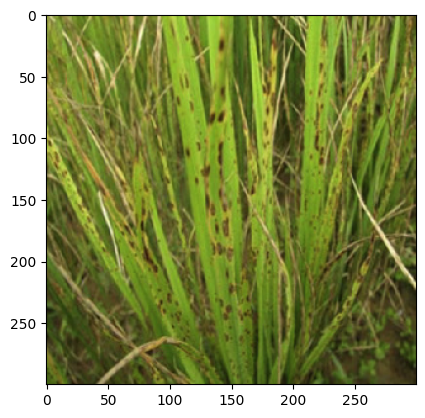

In [ ]:
prediction_aug('3-s2.0-B9780128143834000086-u08-36-9780128143834.jpg')

1/1 [==============================] - 0s 18ms/step
Prediction is Blast


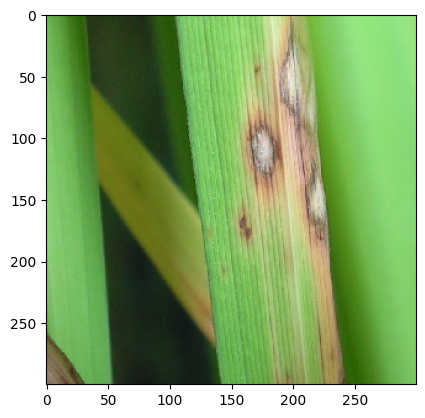

In [ ]:
prediction_aug('csm_DSCN2290_1_Rice_Blast_fungus_infecting_plants_-_Nick_Talbot_24f4e5c0ec.jpg')